In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import clear_output

In [2]:
dataset = torchvision.datasets.MNIST(root='../../data/mnist', train=True, transform=transforms.ToTensor(), download=False)

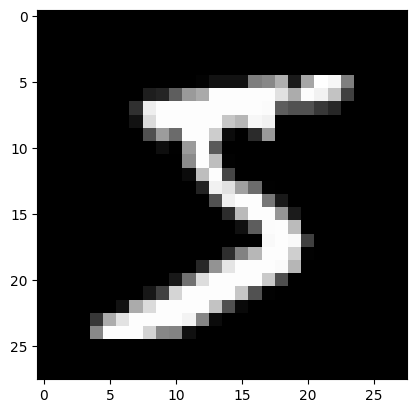

In [3]:
plt.imshow(dataset[0][0].permute(1, 2, 0), cmap='gray');

In [4]:
def show_images(images, title=None):
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid(images).permute(1, 2, 0))
    if title is not None:
        plt.title(title)
    plt.show()

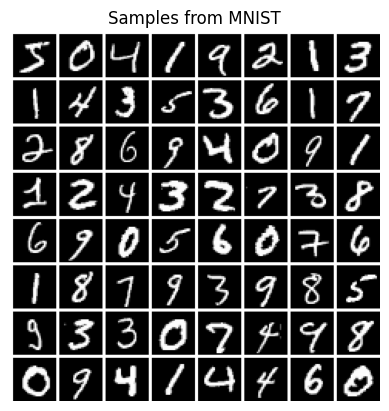

In [5]:
show_images(torch.stack([dataset[i][0] for i in range(64)]), title='Samples from MNIST')

In [47]:
class Generator(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        
        self.net = nn.Sequential(
            self.__basic_block(in_dim, in_dim*2),
            self.__basic_block(in_dim*2, in_dim*4),
            self.__basic_block(in_dim*4, in_dim*8),
            self.__basic_block(in_dim*8, in_dim*16),
            nn.Linear(in_dim*16, out_dim),
            nn.Sigmoid()
        )
    
    def __basic_block(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.net(x)

In [48]:
class Discriminator(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
   
        self.net = nn.Sequential(
            self.__basic_block(in_dim, in_dim//2),
            self.__basic_block(in_dim//2, in_dim//4),
            self.__basic_block(in_dim//4, in_dim//8),
            nn.Linear(in_dim//8, 1)
        )
    
    def __basic_block(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            # nn.BatchNorm1d(output_dim),
            nn.LeakyReLU(),
        )
    
    def forward(self, x):
        return self.net(x)

In [170]:
FLATTENED_IMAGE_SIZE = dataset[0][0].numel()
NOISE_DIM = 64
BATCH_SIZE = 128
NUM_EPOCHS = 100
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


In [194]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(in_dim=NOISE_DIM, out_dim=FLATTENED_IMAGE_SIZE).to(device)
disc = Discriminator(in_dim=FLATTENED_IMAGE_SIZE).to(device)
criterion = nn.BCEWithLogitsLoss()
opt_gen = torch.optim.Adam(gen.parameters(), lr=0.00001)
opt_disc = torch.optim.Adam(disc.parameters(), lr=0.00001)

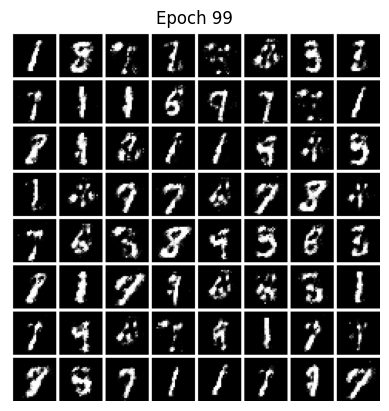

In [195]:
transf = transforms.Compose([transforms.ToPILImage(), transforms.Lambda(lambda x: np.array(x)[:, :, 0])])
images = []

fixed_noise = torch.randn(64, NOISE_DIM).to(device)
for epoch in range(NUM_EPOCHS):
    for real_images, _ in dataloader:
        real_images = real_images.view(-1, FLATTENED_IMAGE_SIZE).to(device)

        #----- Updating the Discriminator -----#
        noise = torch.randn(BATCH_SIZE, NOISE_DIM).to(device)
        fake_images = gen(noise).detach()
        fake_loss = criterion(disc(fake_images), torch.zeros(fake_images.size(0), 1, device=device))
        real_loss = criterion(disc(real_images), torch.ones(real_images.size(0), 1, device=device))
        loss = (fake_loss + real_loss) / 2
        disc.zero_grad()
        loss.backward()
        opt_disc.step()

        #----- Updating the Generator -----#
        noise = torch.randn(BATCH_SIZE, NOISE_DIM).to(device)
        loss = criterion(disc(gen(noise)), torch.ones(noise.size(0), 1, device=device))
        gen.zero_grad()
        loss.backward()
        opt_gen.step()

    clear_output(wait=True)
    show_images(gen(fixed_noise).detach().cpu().view(-1, 1, 28, 28), title=f"Epoch {epoch:2d}")
    images.append(transf(torchvision.utils.make_grid(gen(fixed_noise).detach().cpu().view(-1, 1, 28, 28))))

In [212]:
# video = cv2.VideoWriter("output.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 10, (240, 240), False)
# for image in images:
#     video.write(image)
# video.release()
# cv2.destroyAllWindows()

In [213]:
import imageio
imageio.mimsave('output.gif', images, fps=10)

![](output.gif)